In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
from convokit import Corpus
import pickle
import numpy as np
import os
from tensorly.decomposition import parafac
from convokit.tensors.utils import plot_factors
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from collections import defaultdict, Counter

In [4]:
CORPUS_DIR = "../thread_generator/fake-corpus-trajectory"
# CORPUS_DIR = "reddit-corpus-small"
# CORPUS_DIR =
DATA_DIR = "data_fake_trajectory"
PLOT_DIR = "html/graphs_fake_trajectory"
# hyperconv_range = range(0, 9+1)
hyperconv_range = range(2, 20+1)
rank_range = range(3, 3+1)
max_rank = max(rank_range)
anomaly_threshold = 1.5

In [5]:
os.chdir('convokit/tensors')

In [6]:
with open(os.path.join(DATA_DIR, 'tensor.p'), 'rb') as f:
    tensor = pickle.load(f)

In [7]:
with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
    rank_to_factors = pickle.load(f)

In [8]:
with open(os.path.join(DATA_DIR, 'convo_ids.p'), 'rb') as f:
    convo_ids = pickle.load(f)

In [9]:
tensor.shape

(19, 999, 140)

In [11]:
factors = rank_to_factors[3]

In [12]:
factors[0].shape

(19, 3)

In [13]:
factors[1].shape

(999, 3)

In [14]:
factors[2].shape

(140, 3)

Our intention now is to provide a factorization of subreddits according to the thread types they contain.

In [15]:
anomaly_threshold = 1.5

def get_anomalous_points(factor_full, idx):
    scaler = StandardScaler()
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > anomaly_threshold).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -anomaly_threshold).flatten()
    return pos_pts, neg_pts

def generate_high_level_summary():
    # generate_plots()
    with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
        rank_to_factors = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'hg_features.p'), 'rb') as f:
        liwc_features = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
        subreddits = pickle.load(f)

    time_factor = rank_to_factors[max_rank][0] # (9, 9)
    thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
    feature_factor = rank_to_factors[max_rank][2] # (140, 9)
    idx_to_distinctive_threads = defaultdict(dict)
    idx_to_distinctive_features = defaultdict(dict)

    # normalizing
    subreddit_totals = Counter(subreddits)
    for idx in range(max_rank):
        pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
        idx_to_distinctive_threads[idx]['pos_threads'] = pos_thread_pts
        idx_to_distinctive_threads[idx]['neg_threads'] = neg_thread_pts

        pos_features, neg_features = get_anomalous_points(feature_factor, idx)
        idx_to_distinctive_features[idx]['pos_features'] = pos_features
        idx_to_distinctive_features[idx]['neg_features'] = neg_features

    return idx_to_distinctive_threads, idx_to_distinctive_features 

In [16]:
idx_to_distinctive_threads, idx_to_distinctive_features = generate_high_level_summary()

In [17]:
for factor_idx, threads in idx_to_distinctive_threads.items():
    print("Factor {}".format(factor_idx+1))
    print("Number of pos threads: {}".format(len(threads['pos_threads'])))
    print("Number of neg threads: {}".format(len(threads['neg_threads'])))
    print("Positive feats: {}".format(idx_to_distinctive_features[factor_idx]['pos_features']))
    print("Negative feats: {}".format(idx_to_distinctive_features[factor_idx]['neg_features']))
    print()

Factor 1
Number of pos threads: 0
Number of neg threads: 118
Positive feats: [67]
Negative feats: []

Factor 2
Number of pos threads: 105
Number of neg threads: 0
Positive feats: [  4  12  18  21  24  26  61  82  88  94  96 131]
Negative feats: [67]

Factor 3
Number of pos threads: 126
Number of neg threads: 37
Positive feats: [ 61  94 131]
Negative feats: [ 0 13 14 20 37 63 67 69]



In [18]:
included_threads = set()

for factor_idx, threads in idx_to_distinctive_threads.items():
    included_threads = included_threads.union(set(threads['pos_threads'])).union(threads['neg_threads'])

In [19]:
len(included_threads)

293

In [20]:
thread_cnt = defaultdict(int)
for factor_idx, threads in idx_to_distinctive_threads.items():
    for t in threads['pos_threads']: 
        thread_cnt[t] += 1
    for t in threads['neg_threads']:
        thread_cnt[t] += 1

In [21]:
appears_once = [t for t, v in thread_cnt.items() if v == 1]

In [22]:
len(appears_once)

200

We decide to include only threads that appear in a single factor.

We say each thread belongs to one of the factors: Factor 1 to Factor 9.
Now, we identify the subreddits of each thread and assign a percentage value for each factor to each of the subreddits.

In [23]:
corpus = Corpus(filename=CORPUS_DIR)

In [24]:
convo_id_to_factor = dict()
for factor_idx, threads in idx_to_distinctive_threads.items():
    for t in threads['pos_threads']: 
        convo_id_to_factor[convo_ids[t]] = factor_idx
    for t in threads['neg_threads']:
        convo_id_to_factor[convo_ids[t]] = factor_idx

In [25]:
subreddit_to_thread_factors = dict()
for convo_idx in appears_once:
    convo = corpus.get_utterance(convo_ids[convo_idx])
    subreddit = convo.meta['subreddit']
    if subreddit not in subreddit_to_thread_factors:
        subreddit_to_thread_factors[subreddit] = defaultdict(int)
    
    subreddit_to_thread_factors[subreddit][convo_id_to_factor[convo.id]] += 1

In [26]:
threads_per_subreddit = dict()
for sub, d_ in subreddit_to_thread_factors.items():
    threads_per_subreddit[sub] = sum(list(d_.values()))

In [27]:
print(min(threads_per_subreddit.values()))
print(max(threads_per_subreddit.values()))

29
120


In [28]:
# normalize at subreddit-level
for sub, factor_cnts in subreddit_to_thread_factors.items():
    total_ = sum(list(factor_cnts.values()))
    for k, v in factor_cnts.items():
        factor_cnts[k] = v / total_

In [30]:
# subreddit_to_thread_factors['2007scape']

In [31]:
import pandas as pd

In [32]:
subreddit_df = pd.DataFrame.from_dict(subreddit_to_thread_factors, orient='index')

In [33]:
from sklearn.preprocessing import Imputer

In [34]:
subreddit_df = subreddit_df.fillna(0)

In [35]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

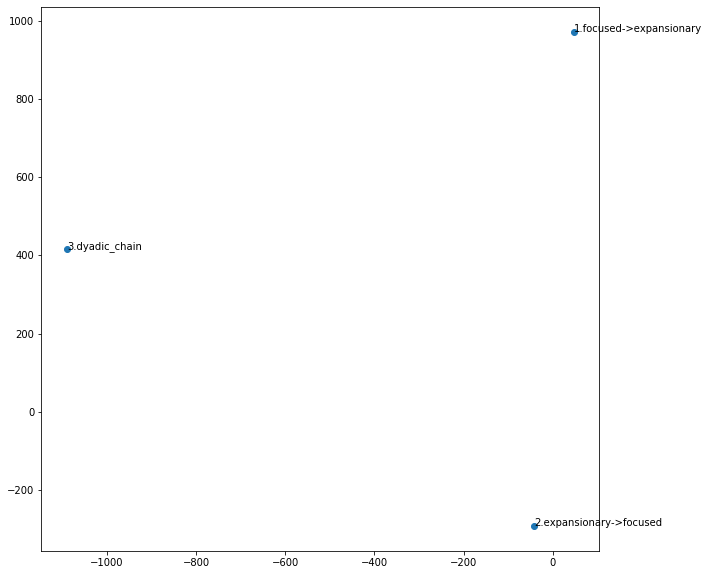

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

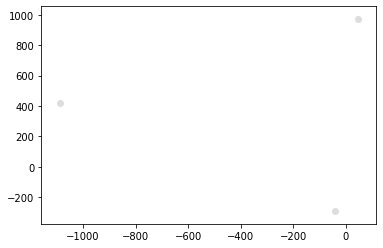

In [37]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()